In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Circle
import numpy as np
import os
import sys

In [76]:
sys.path.append('../src/')

In [77]:
from modules import helpers as hp
from modules import mammoscan as ms

In [78]:
final_results_benign = hp.create_final_results_df()
final_results_benign

,test_accuracy,precision,recall,f1-score
calcifications,0,0,0,0


In [79]:
final_results_malignant = hp.create_final_results_df()

In [80]:
final_results_benign.loc['calcifications'] = [0.99, 0.97, 1.00, 0.98]
final_results_benign.loc['masses_full_bal'] = [0.96, 0.90, 0.90, 0.90]
final_results_benign.loc['masses_bal'] = [0.95, 0.98, 0.87, 0.92]
final_results_benign.loc['all_full_bal'] = [0.91, 0.74, 0.78, 0.76]
final_results_benign.loc['all_bal'] = [0.93, 0.79, 0.84, 0.81]
final_results_benign

,test_accuracy,precision,recall,f1-score
calcifications,0.99,0.97,1.00,0.98
masses_full_bal,0.96,0.90,0.90,0.90
masses_bal,0.95,0.98,0.87,0.92
all_full_bal,0.91,0.74,0.78,0.76
all_bal,0.93,0.79,0.84,0.81


In [81]:
final_results_malignant.loc['calcifications'] = [0.99, 1.00, 0.97, 0.98]
final_results_malignant.loc['masses_full_bal'] = [0.96, 0.88, 0.88, 0.88]
final_results_malignant.loc['masses_bal'] = [0.95, 0.90, 0.98, 0.94]
final_results_malignant.loc['all_full_bal'] = [0.91, 0.82, 0.82, 0.82]
final_results_malignant.loc['all_bal'] = [0.93,0.84,0.85,0.84]
final_results_malignant 

,test_accuracy,precision,recall,f1-score
calcifications,0.99,1.00,0.97,0.98
masses_full_bal,0.96,0.88,0.88,0.88
masses_bal,0.95,0.90,0.98,0.94
all_full_bal,0.91,0.82,0.82,0.82
all_bal,0.93,0.84,0.85,0.84


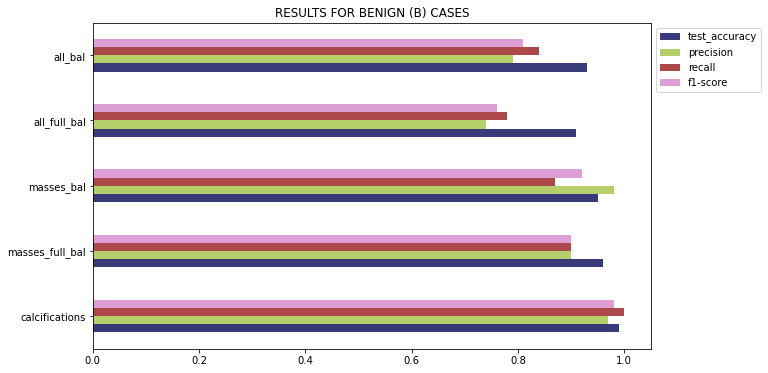

In [88]:
ax = final_results_benign.plot(kind='barh', 
                          figsize=(10, 6), 
                          legend={'reverse'},
                          title='RESULTS FOR BENIGN (B) CASES',
                          cmap = plt.cm.get_cmap('tab20b')
                          );

ax.legend(bbox_to_anchor=(1.0, 1.0))

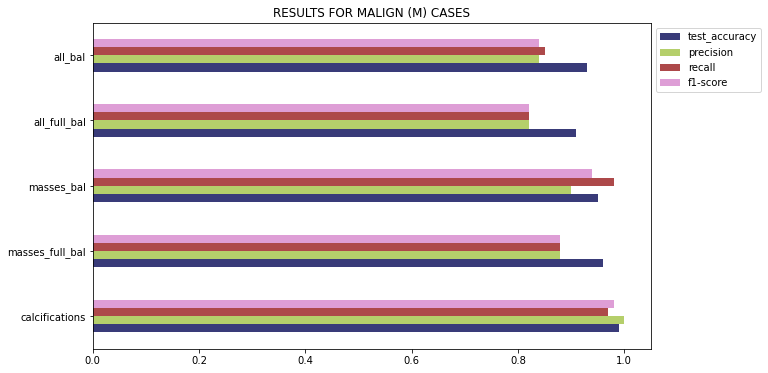

In [85]:
ax = final_results_malignant.plot(kind='barh', 
                          figsize=(10, 6), 
                          legend={'reverse'},
                          title='RESULTS FOR MALIGN (M) CASES',
                          cmap = plt.cm.get_cmap('tab20b'));

ax.legend(bbox_to_anchor=(1.0, 1.0))

In [4]:
plt.style.use('dark_background') # comment or delete it for light background

In [5]:
mammo = pd.read_table('../scan_file_data.txt', delimiter='\s', engine='python')

In [6]:
# rename the class column to avoid conflicts with the class keyword in python
mammo.columns = ['refnum', 'bg', 'ab_class', 'severity', 'x', 'y', 'radius']

<AxesSubplot:>

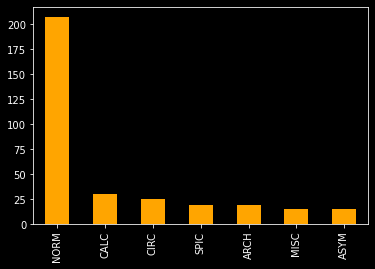

In [7]:
mammo.ab_class.value_counts().plot(kind='bar', color='orange')

<AxesSubplot:>

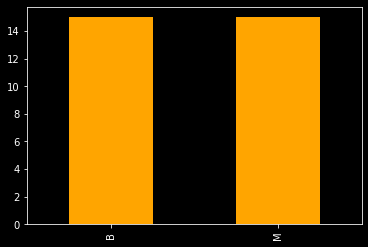

In [8]:
mammo.loc[mammo['ab_class'] == 'CALC'].severity.value_counts().plot(kind='bar', color='orange')

<AxesSubplot:>

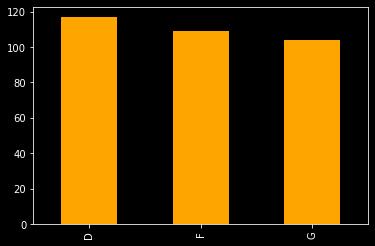

In [9]:
mammo.bg.value_counts().plot(kind='bar', color='orange')

In [10]:
mammo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   refnum    330 non-null    object 
 1   bg        330 non-null    object 
 2   ab_class  330 non-null    object 
 3   severity  123 non-null    object 
 4   x         122 non-null    object 
 5   y         122 non-null    object 
 6   radius    119 non-null    float64
dtypes: float64(1), object(6)
memory usage: 18.2+ KB


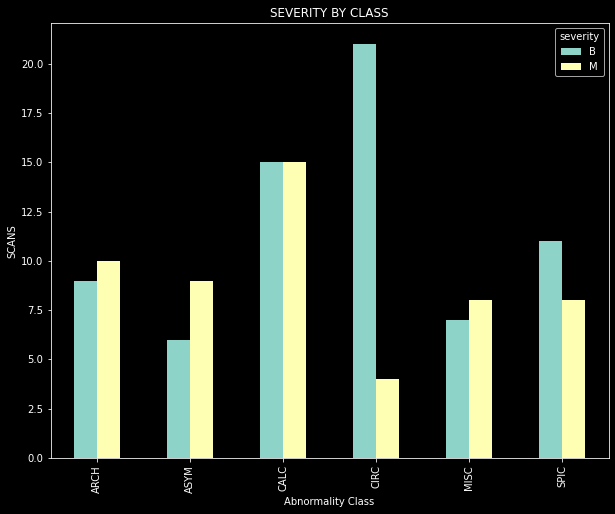

In [11]:
mx = mammo.groupby(['ab_class', 'severity']).size().unstack().plot(kind='bar', 
                                                                   figsize=(10, 8), 
                                                                   xlabel='Abnormality Class', 
                                                                   ylabel='SCANS',
                                                                   title='SEVERITY BY CLASS')


In [12]:
ab_sev = mammo.groupby(['ab_class', 'severity']).size()

In [13]:
ab_sev = mammo.groupby('ab_class').severity.value_counts(normalize=True)
ab_sev

ab_class  severity
ARCH      M           0.526316
          B           0.473684
ASYM      M           0.600000
          B           0.400000
CALC      B           0.500000
          M           0.500000
CIRC      B           0.840000
          M           0.160000
MISC      M           0.533333
          B           0.466667
SPIC      B           0.578947
          M           0.421053
Name: severity, dtype: float64

<ipython-input-14-5fbc8788e17a>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:.2%}' for x in vals]);


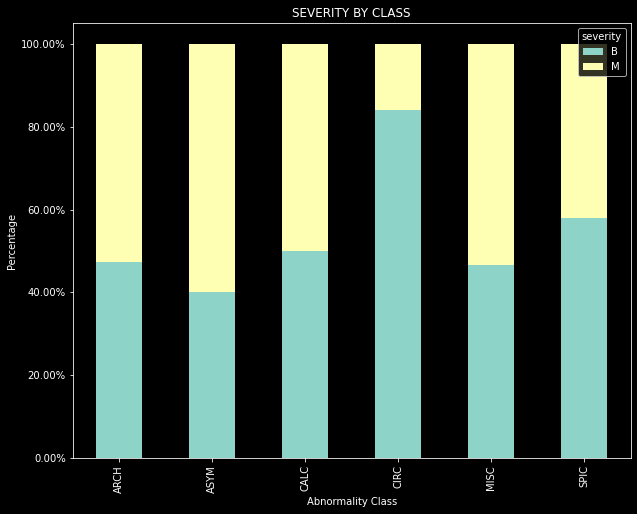

In [14]:
ax = ab_sev.unstack().plot(kind='bar', 
                      stacked=True, 
                      figsize=(10, 8), 
                      xlabel='Abnormality Class', 
                      ylabel='Percentage',
                      title='SEVERITY BY CLASS');

# manipulate
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:.2%}' for x in vals]);

In [15]:
# get indices of the norm class only
norms = lambda x: x == 'NORM'
mammo.severity = mammo.severity.fillna('A')

In [16]:
from pathlib import Path
import re

INITIALLY REMOVE ONLY THE SCANS WITHOUT INVALID X ENTRY *NOTE

In [17]:
test_df = mammo.copy()

In [18]:
test_df

,refnum,bg,ab_class,severity,x,y,radius
0,mdb001,G,CIRC,B,535,425,197.0
1,mdb002,G,CIRC,B,522,280,69.0
2,mdb003,D,NORM,A,None,None,NaN
3,mdb004,D,NORM,A,None,None,NaN
4,mdb005,F,CIRC,B,477,133,30.0
...,...,...,...,...,...,...,...
325,mdb318,D,NORM,A,None,None,NaN
326,mdb319,D,NORM,A,None,None,NaN
327,mdb320,D,NORM,A,None,None,NaN
328,mdb321,D,NORM,A,None,None,NaN


In [19]:
test_df.drop_duplicates(subset='refnum', keep='first', inplace=True)

In [20]:
test_df.set_index(keys='refnum', drop=True, inplace=True)

In [21]:
test_df.index;

In [22]:
clean_df = hp.clean_ds_files(test_df)

In [23]:
clean_df.head()

,bg,ab_class,severity,x,y,radius
refnum,,,,,,
mdb001,G,CIRC,B,535.0,425.0,197.0
mdb002,G,CIRC,B,522.0,280.0,69.0
mdb003,D,NORM,A,NaN,NaN,NaN
mdb004,D,NORM,A,NaN,NaN,NaN
mdb005,F,CIRC,B,477.0,133.0,30.0


In [24]:
# save clean to file
clean_df.to_csv('test_df.csv')

In [25]:
type(clean_df.loc['mdb005'])

pandas.core.series.Series

In [26]:
scan_info = clean_df.loc['mdb003'].copy() # need to ensure we get a deep copy of the Series to avoid changing a value in it and keeping the reference
scan_info

bg             D
ab_class    NORM
severity       A
x            NaN
y            NaN
radius       NaN
Name: mdb003, dtype: object

In [27]:
from PIL import Image

In [28]:
test_img = Image.open('../all-mias/mdb003.pgm')

In [29]:
test = ms.MammoScan(test_img, scan_info)

In [30]:
test.pixel_matrix.shape

(1024, 1024)

501.0, 514.0, 48.0


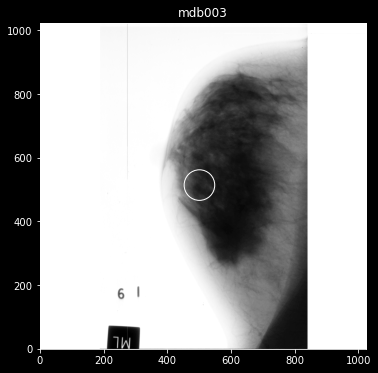

In [31]:
test.plot()

In [32]:
transformed = test.transformations
transformed

{0: {'rotated': <PIL.Image.Image image mode=L size=48x48 at 0x7FA7B4C68EE0>,
  'mirr_lr': <PIL.Image.Image image mode=L size=48x48 at 0x7FA7B4C76A00>,
  'mirr_tp': <PIL.Image.Image image mode=L size=48x48 at 0x7FA7B4A3D790>},
 90: {'rotated': <PIL.Image.Image image mode=L size=48x48 at 0x7FA7B4C3C5E0>,
  'mirr_lr': <PIL.Image.Image image mode=L size=48x48 at 0x7FA7B4F8BDC0>,
  'mirr_tp': <PIL.Image.Image image mode=L size=48x48 at 0x7FA7B4AFCD00>},
 180: {'rotated': <PIL.Image.Image image mode=L size=48x48 at 0x7FA7B474B400>,
  'mirr_lr': <PIL.Image.Image image mode=L size=48x48 at 0x7FA7B474BD30>,
  'mirr_tp': <PIL.Image.Image image mode=L size=48x48 at 0x7FA7B5274AF0>},
 270: {'rotated': <PIL.Image.Image image mode=L size=48x48 at 0x7FA7B52748B0>,
  'mirr_lr': <PIL.Image.Image image mode=L size=48x48 at 0x7FA7B5274C40>,
  'mirr_tp': <PIL.Image.Image image mode=L size=48x48 at 0x7FA7B52743D0>}}

In [33]:
'''

for angle, imgs in transformed.items():
    for transf, img in imgs.items():
        print(f'{angle}, {transf}')
        print(np.asarray(img))
        display(img)
        
'''        
        
# 90 degrees left-right == 270 degree top-bottom
# 0 degrees left-right == 180 top-bottom
# drop duplicates???

"\n\nfor angle, imgs in transformed.items():\n    for transf, img in imgs.items():\n        print(f'{angle}, {transf}')\n        print(np.asarray(img))\n        display(img)\n        \n"

In [34]:
scans_filenames_dic = hp.create_scan_filenames_dic('../all-mias/')

### Check the quality of crops

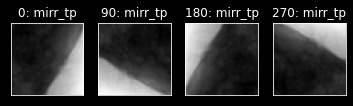

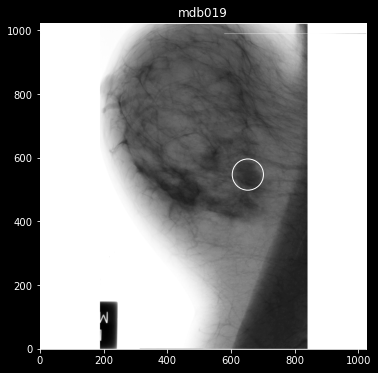

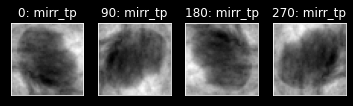

In [35]:
counter = 0
for scan_name, filename in scans_filenames_dic.items():
        # create image and scan info objects
        try:
            scan = Image.open(filename)
        except FileNotFoundError as fnf:
            print({fnf})
            
        scan_info = clean_df.loc[scan_name].copy()
        print(scan_info.name)
        # create the MammoScan object
        m_scan = ms.MammoScan(scan, scan_info)
        
        m_scan.plot()
        # get the transformations
        transf_scans = m_scan.transformations
        
        figure, axes = plt.subplots(nrows=1, ncols=4, figsize=(6, 6))
        
        for item in zip(axes.ravel(), transf_scans.items()):
            axes, images = item
            angle, transfs = images
            for transf, img in transfs.items():
                axes.imshow(img, cmap=plt.cm.gray_r)
                axes.set_xticks([]) # remove x-axis tick marks
                axes.set_yticks([]) # remove y-axis tick marks
                axes.set_title(f'{angle}: {transf}')
        # plt.tight_layout
        counter+= 1
        if counter == 19:
            break


In [36]:
test_sub = hp.save_subsamples(scans_filenames_dic, clean_df)

In [37]:
test_sub

,ab_class,bg,severity,subsample_path
mdb001_0_rotated,CIRC,G,B,../subsamples/mdb001_0_rotated.png
mdb001_0_mirr_lr,CIRC,G,B,../subsamples/mdb001_0_mirr_lr.png
mdb001_0_mirr_tp,CIRC,G,B,../subsamples/mdb001_0_mirr_tp.png
mdb001_90_rotated,CIRC,G,B,../subsamples/mdb001_90_rotated.png
mdb001_90_mirr_lr,CIRC,G,B,../subsamples/mdb001_90_mirr_lr.png
...,...,...,...,...
mdb322_180_mirr_lr,NORM,D,A,../subsamples/mdb322_180_mirr_lr.png
mdb322_180_mirr_tp,NORM,D,A,../subsamples/mdb322_180_mirr_tp.png
mdb322_270_rotated,NORM,D,A,../subsamples/mdb322_270_rotated.png
mdb322_270_mirr_lr,NORM,D,A,../subsamples/mdb322_270_mirr_lr.png


### TRAIN AND EVALUATE MODEL FOR THE MASSES

In [38]:
# TRAIN AND TEST DATA FOR THE MASSES
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [39]:
masses = test_sub[(test_sub.ab_class == 'CIRC') | 
                  (test_sub.ab_class == 'SPIC') | 
                  (test_sub.ab_class == 'MISC')]

In [41]:
#X_train, X_test = train_test_split(masses, 
 #                                  test_size=.25, 
  #                                 random_state=42, 
   #                                stratify=masses.severity)

In [42]:
data_generator = ImageDataGenerator(width_shift_range=.1, 
                                    height_shift_range=.1, 
                                    rotation_range=180,
                                    zoom_range=.1,
                                    horizontal_flip=True,
                                    validation_split=.2)

In [43]:
masses.info()

<class 'pandas.core.frame.DataFrame'>
Index: 672 entries, mdb001_0_rotated to mdb315_270_mirr_tp
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ab_class        672 non-null    object
 1   bg              672 non-null    object
 2   severity        672 non-null    object
 3   subsample_path  672 non-null    object
dtypes: object(4)
memory usage: 26.2+ KB


In [44]:
train_data = data_generator.flow_from_dataframe(masses, 
                                                x_col="subsample_path", 
                                                y_col="severity",
                                                class_mode="categorical",
                                                target_size=(48,48),
                                                subset="training",
                                                color_mode="grayscale",
                                                shuffle=True)
test_data = data_generator.flow_from_dataframe(masses, 
                                               x_col="subsample_path", 
                                               y_col="severity",
                                               class_mode="categorical",
                                               target_size=(48,48),
                                               subset="validation",
                                               color_mode="grayscale",
                                               shuffle=False)


Found 538 validated image filenames belonging to 2 classes.
Found 134 validated image filenames belonging to 2 classes.


In [45]:
# create neural network
from tensorflow.keras.models import Sequential

In [46]:
cnn_mass = Sequential()

In [47]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

In [48]:
# add layers
cnn_mass.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(48, 48, 1)))

In [49]:
# Add a Pooling Layer
cnn_mass.add(MaxPooling2D(pool_size=(2, 2)))

In [50]:
cnn_mass.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))

In [51]:
cnn_mass.add(MaxPooling2D(pool_size=(2,2)))

#### Flattening the results

In [52]:
cnn_mass.add(Flatten())

#### Add dense layer to reduce the number of features

In [53]:
from tensorflow.keras.layers import Dropout


In [54]:
cnn_mass.add(Dropout(0.5)) # to avoid overfitting , drop 50%

In [55]:
cnn_mass.add(Dense(units=1024, activation='relu'))

#### Dense layer to produce final output

In [56]:
cnn_mass.add(Dense(units=2, activation='softmax')) # 2 units - B/ M

In [57]:
cnn_mass.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 44, 44, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 5184)              0         
_________________________________________________________________
dropout (Dropout)            (None, 5184)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              5

#### Visualise the Model's Structure

In [58]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

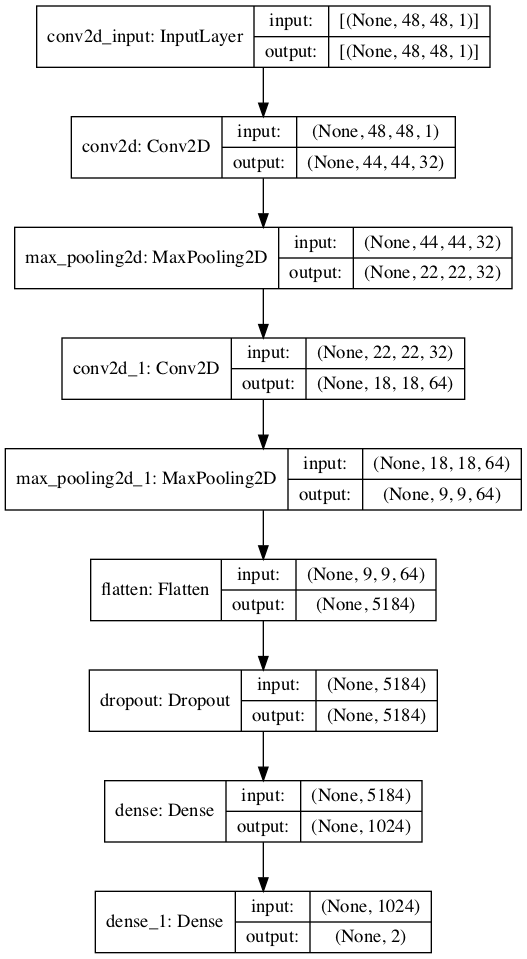

In [59]:
plot_model(cnn_mass, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png')

In [60]:
cnn_mass.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

#### Training and Evaluating the Model

In [61]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [62]:
test_data.batch_size

32

In [63]:
cnn_mass.fit(train_data, 
             validation_data=test_data, 
             epochs=100, 
             batch_size=32,
             callbacks=[early_stopping])

Epoch 1/100
17/17 [==============================] - 2s 104ms/step - loss: 182.1242 - accuracy: 0.5142 - val_loss: 0.6881 - val_accuracy: 0.8731
Epoch 2/100
17/17 [==============================] - 1s 78ms/step - loss: 0.7785 - accuracy: 0.5822 - val_loss: 0.6707 - val_accuracy: 0.8955
Epoch 3/100
17/17 [==============================] - 1s 82ms/step - loss: 0.6936 - accuracy: 0.6098 - val_loss: 0.6451 - val_accuracy: 0.9030
Epoch 4/100
17/17 [==============================] - 1s 82ms/step - loss: 0.7721 - accuracy: 0.5848 - val_loss: 0.6492 - val_accuracy: 0.8955
Epoch 5/100
17/17 [==============================] - 1s 81ms/step - loss: 0.7014 - accuracy: 0.5751 - val_loss: 0.6441 - val_accuracy: 0.8881
Epoch 6/100
17/17 [==============================] - 1s 83ms/step - loss: 0.7022 - accuracy: 0.5883 - val_loss: 0.6228 - val_accuracy: 0.9030
Epoch 7/100
17/17 [==============================] - 2s 90ms/step - loss: 0.7531 - accuracy: 0.5968 - val_loss: 0.6095 - val_accuracy: 0.9104
Epo

#### Making predictions

In [64]:
y_pred = cnn_mass.predict(test_data)

In [65]:
y_pred[0]

array([0.5993091 , 0.40069088], dtype=float32)

In [66]:
test_data.class_indices

{'B': 0, 'M': 1}

In [67]:
predicted = [np.argmax(w) for w in y_pred]
expected = test_data.labels

In [68]:
from sklearn.metrics import confusion_matrix, classification_report

In [69]:
confusion_matrix(expected, predicted)

array([[122,   0],
       [ 12,   0]])

In [70]:
print(classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       122
           1       0.00      0.00      0.00        12

    accuracy                           0.91       134
   macro avg       0.46      0.50      0.48       134
weighted avg       0.83      0.91      0.87       134



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### TRAIN AND EVALUATE MODEL FOR CALCIFICATIONS

In [38]:
# TRAIN AND TEST DATA FOR THE MASSES
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [39]:
calcifications = test_sub[(test_sub.ab_class == 'CALC')]

In [70]:
from sklearn.model_selection import train_test_split

In [71]:
X_train, X_test = train_test_split(calcifications, 
                                   test_size=.25, 
                                   random_state=42, 
                                   stratify=calcifications.severity)

In [72]:
X_train.groupby(['severity']).count()

,ab_class,bg,subsample_path
severity,,,
B,108,108,108
M,90,90,90


In [73]:
X_test.subsample_path.nunique()

66

In [74]:
X_test.groupby(['severity']).count()

,ab_class,bg,subsample_path
severity,,,
B,36,36,36
M,30,30,30


In [75]:
calcifications.shape

(264, 4)

In [76]:
# get the images corresponding to xtrain
X_train

,ab_class,bg,severity,subsample_path
mdb248_90_rotated,CALC,F,B,../subsamples/mdb248_90_rotated.png
mdb241_0_mirr_tp,CALC,D,M,../subsamples/mdb241_0_mirr_tp.png
mdb212_90_mirr_tp,CALC,G,B,../subsamples/mdb212_90_mirr_tp.png
mdb248_0_rotated,CALC,F,B,../subsamples/mdb248_0_rotated.png
mdb227_0_mirr_lr,CALC,G,B,../subsamples/mdb227_0_mirr_lr.png
...,...,...,...,...
mdb219_180_mirr_lr,CALC,G,B,../subsamples/mdb219_180_mirr_lr.png
mdb240_270_mirr_lr,CALC,D,B,../subsamples/mdb240_270_mirr_lr.png
mdb213_0_rotated,CALC,G,M,../subsamples/mdb213_0_rotated.png
mdb239_0_rotated,CALC,D,M,../subsamples/mdb239_0_rotated.png


In [77]:
data_generator = ImageDataGenerator(width_shift_range=.1, 
                                    height_shift_range=.1, 
                                    rotation_range=180,
                                    zoom_range=.1,
                                    horizontal_flip=True,
                                    validation_split=.2)

In [78]:
train_data = data_generator.flow_from_dataframe(X_train, 
                                                x_col="subsample_path", 
                                                y_col="severity",
                                                class_mode="categorical",
                                                target_size=(48,48),
                                                #subset="training",
                                                color_mode="grayscale",
                                                shuffle=True)
test_data = data_generator.flow_from_dataframe(X_test, 
                                               x_col="subsample_path", 
                                               y_col="severity",
                                               class_mode="categorical",
                                               target_size=(48,48),
                                               #subset="validation",
                                               color_mode="grayscale",
                                               shuffle=False)


Found 198 validated image filenames belonging to 2 classes.
Found 66 validated image filenames belonging to 2 classes.


In [79]:
sum(train_data.labels) / len(train_data.labels)

0.45454545454545453

In [80]:
sum(test_data.labels) / len(test_data.labels)

0.45454545454545453

In [81]:
52 * 0.7

36.4

In [82]:
# create neural network
from tensorflow.keras.models import Sequential

In [83]:
cnn_calc = Sequential()

In [84]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

In [85]:
# add layers
cnn_calc.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(48, 48, 1)))

In [86]:
# Add a Pooling Layer
cnn_calc.add(MaxPooling2D(pool_size=(2, 2)))

In [87]:
cnn_calc.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))

In [88]:
cnn_calc.add(MaxPooling2D(pool_size=(2,2)))

#### Flattening the results

In [89]:
cnn_calc.add(Flatten())

#### Add dense layer to reduce the number of features

In [90]:
from tensorflow.keras.layers import Dropout


In [91]:
cnn_calc.add(Dropout(0.5)) # to avoid overfitting , drop 50%

In [92]:
cnn_calc.add(Dense(units=1024, activation='relu'))

#### Dense layer to produce final output

In [93]:
cnn_calc.add(Dense(units=2, activation='softmax')) # 2 units - B/ M

In [94]:
cnn_calc.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 44, 44, 32)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 64)        51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5184)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)             

#### Visualise the Model's Structure

In [95]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

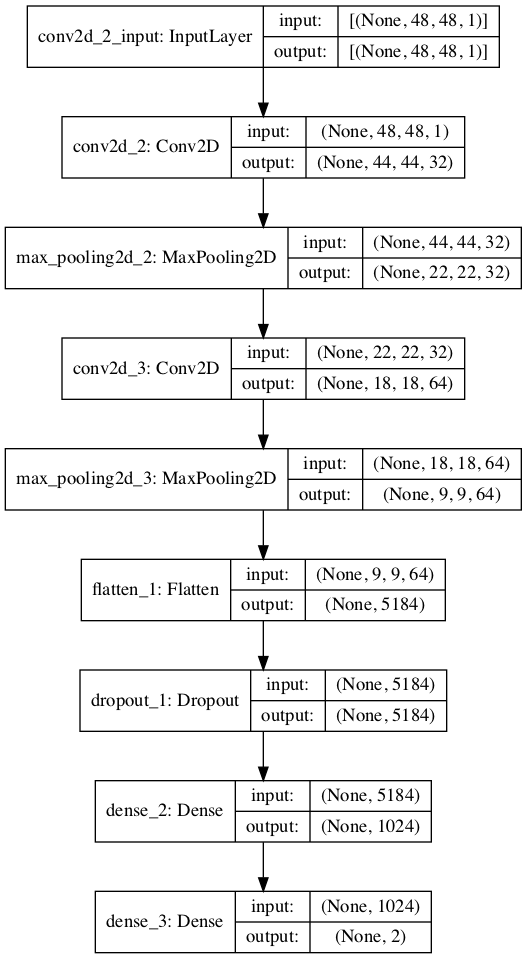

In [96]:
plot_model(cnn_calc, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png')

In [97]:
cnn_calc.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

#### Training and Evaluating the Model

In [98]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=20, restore_best_weights=True)

In [99]:
test_data.batch_size

32

In [100]:
cnn_calc.fit(train_data, 
             validation_data=test_data, 
             epochs=100, 
             batch_size=32,
             callbacks=[early_stopping])

Epoch 1/100
7/7 [==============================] - 1s 141ms/step - loss: 108.0608 - accuracy: 0.4838 - val_loss: 2.7380 - val_accuracy: 0.4545
Epoch 2/100
7/7 [==============================] - 1s 99ms/step - loss: 2.4794 - accuracy: 0.4705 - val_loss: 0.6955 - val_accuracy: 0.4091
Epoch 3/100
7/7 [==============================] - 1s 95ms/step - loss: 0.6962 - accuracy: 0.5388 - val_loss: 0.6919 - val_accuracy: 0.5606
Epoch 4/100
7/7 [==============================] - 1s 94ms/step - loss: 0.6891 - accuracy: 0.6229 - val_loss: 0.6915 - val_accuracy: 0.5758
Epoch 5/100
7/7 [==============================] - 1s 95ms/step - loss: 0.6894 - accuracy: 0.6326 - val_loss: 0.6906 - val_accuracy: 0.5606
Epoch 6/100
7/7 [==============================] - 1s 91ms/step - loss: 0.6833 - accuracy: 0.6180 - val_loss: 0.6869 - val_accuracy: 0.5455
Epoch 7/100
7/7 [==============================] - 1s 97ms/step - loss: 0.6872 - accuracy: 0.5507 - val_loss: 0.6866 - val_accuracy: 0.6212
Epoch 8/100
7/7 [

#### Making predictions

In [101]:
y_pred = cnn_calc.predict(test_data)

In [102]:
y_pred[0]

array([0.5283807 , 0.47161934], dtype=float32)

In [103]:
test_data.class_indices

{'B': 0, 'M': 1}

In [104]:
predicted = [np.argmax(w) for w in y_pred]
expected = test_data.labels

In [105]:
from sklearn.metrics import confusion_matrix, classification_report

In [106]:
confusion_matrix(expected, predicted)

array([[33,  3],
       [20, 10]])

In [107]:
print(classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.62      0.92      0.74        36
           1       0.77      0.33      0.47        30

    accuracy                           0.65        66
   macro avg       0.70      0.62      0.60        66
weighted avg       0.69      0.65      0.62        66



### TRAIN AND EVALUATE MODEL FOR ARCHITECTURAL DISTORTION

In [214]:
# TRAIN AND TEST DATA FOR THE MASSES
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [110]:
archs = test_sub[(test_sub.ab_class == 'ARCH')]

In [111]:
data_generator = ImageDataGenerator(width_shift_range=.1, 
                                    height_shift_range=.1, 
                                    rotation_range=180,
                                    zoom_range=.1,
                                    horizontal_flip=True,
                                    validation_split=.2)

In [112]:
train_data = data_generator.flow_from_dataframe(archs, 
                                                x_col="subsample_path", 
                                                y_col="severity",
                                                class_mode="categorical",
                                                target_size=(48,48),
                                                subset="training",
                                                color_mode="grayscale",
                                                shuffle=True)
test_data = data_generator.flow_from_dataframe(archs, 
                                               x_col="subsample_path", 
                                               y_col="severity",
                                               class_mode="categorical",
                                               target_size=(48,48),
                                               subset="validation",
                                               color_mode="grayscale",
                                               shuffle=False)


Found 183 validated image filenames belonging to 2 classes.
Found 45 validated image filenames belonging to 2 classes.


In [113]:
# create neural network
from tensorflow.keras.models import Sequential

In [114]:
cnn_archs = Sequential()

In [115]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

In [116]:
# add layers
cnn_archs.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(48, 48, 1)))

In [117]:
# Add a Pooling Layer
cnn_archs.add(MaxPooling2D(pool_size=(2, 2)))

In [118]:
cnn_archs.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))

In [119]:
cnn_archs.add(MaxPooling2D(pool_size=(2,2)))

#### Flattening the results

In [120]:
cnn_archs.add(Flatten())

#### Add dense layer to reduce the number of features

In [121]:
from tensorflow.keras.layers import Dropout


In [122]:
cnn_archs.add(Dropout(0.5)) # to avoid overfitting , drop 50%

In [123]:
cnn_archs.add(Dense(units=1024, activation='relu'))

#### Dense layer to produce final output

In [124]:
cnn_archs.add(Dense(units=2, activation='softmax')) # 2 units - B/ M

In [125]:
cnn_archs.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 44, 44, 32)        832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 18, 18, 64)        51264     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5184)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5184)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)             

#### Visualise the Model's Structure

In [126]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

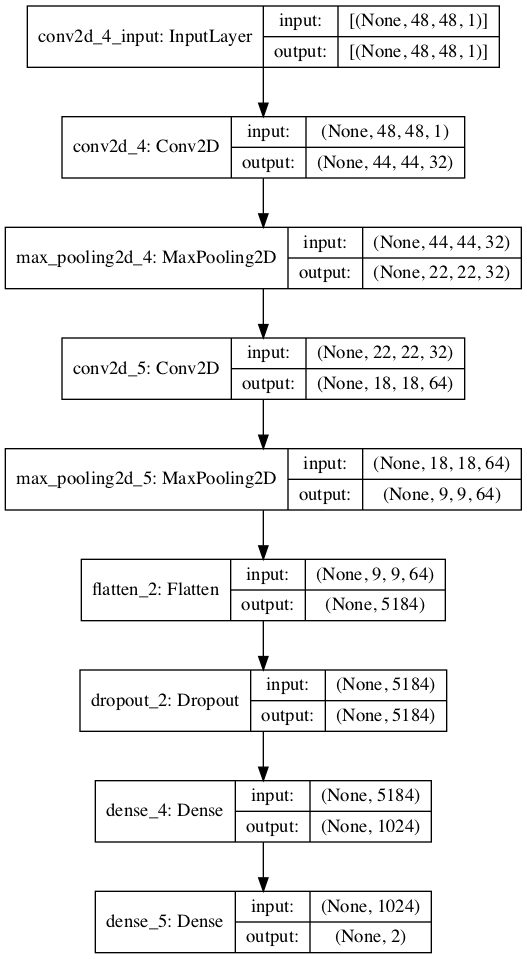

In [127]:
plot_model(cnn_archs, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png')

In [128]:
cnn_archs.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

#### Training and Evaluating the Model

In [129]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [130]:
test_data.batch_size

32

In [131]:
cnn_archs.fit(train_data, 
             validation_data=test_data, 
             epochs=100, 
             batch_size=32,
             callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - 1s 146ms/step - loss: 100.8079 - accuracy: 0.4777 - val_loss: 52.8347 - val_accuracy: 0.2000
Epoch 2/100
6/6 [==============================] - 1s 92ms/step - loss: 19.7173 - accuracy: 0.4887 - val_loss: 1.3427 - val_accuracy: 0.3333
Epoch 3/100
6/6 [==============================] - 1s 92ms/step - loss: 0.7375 - accuracy: 0.4783 - val_loss: 0.6914 - val_accuracy: 0.8000
Epoch 4/100
6/6 [==============================] - 1s 99ms/step - loss: 0.9998 - accuracy: 0.5298 - val_loss: 0.6918 - val_accuracy: 0.7778
Epoch 5/100
6/6 [==============================] - 1s 106ms/step - loss: 0.6626 - accuracy: 0.5387 - val_loss: 0.6868 - val_accuracy: 0.8000
Epoch 6/100
6/6 [==============================] - 1s 92ms/step - loss: 0.6627 - accuracy: 0.4948 - val_loss: 0.7227 - val_accuracy: 0.7111
Epoch 7/100
6/6 [==============================] - 1s 89ms/step - loss: 0.6454 - accuracy: 0.5156 - val_loss: 0.6874 - val_accuracy: 0.8000
Epoch 8/100
6/

#### Making predictions

In [132]:
y_pred = cnn_archs.predict(test_data)

In [133]:
y_pred[0]

array([0.49502787, 0.5049721 ], dtype=float32)

In [134]:
test_data.class_indices

{'B': 0, 'M': 1}

In [135]:
predicted = [np.argmax(w) for w in y_pred]
expected = test_data.labels

In [136]:
from sklearn.metrics import confusion_matrix, classification_report

In [137]:
confusion_matrix(expected, predicted)

array([[ 0,  9],
       [ 1, 35]])

In [138]:
print(classification_report(expected, predicted, zero_division='warn'))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.80      0.97      0.88        36

    accuracy                           0.78        45
   macro avg       0.40      0.49      0.44        45
weighted avg       0.64      0.78      0.70        45



### TRAIN AND EVALUATE MODEL FOR ASYMMETRY

In [139]:
# TRAIN AND TEST DATA FOR THE ASYMMETRY
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [140]:
asym = test_sub[(test_sub.ab_class == 'ASYM')]

In [141]:
data_generator = ImageDataGenerator(width_shift_range=.1, 
                                    height_shift_range=.1, 
                                    rotation_range=180,
                                    zoom_range=.1,
                                    horizontal_flip=True,
                                    validation_split=.2)

In [142]:
train_data = data_generator.flow_from_dataframe(asym, 
                                                x_col="subsample_path", 
                                                y_col="severity",
                                                class_mode="categorical",
                                                target_size=(48,48),
                                                subset="training",
                                                color_mode="grayscale",
                                                shuffle=True)
test_data = data_generator.flow_from_dataframe(asym, 
                                               x_col="subsample_path", 
                                               y_col="severity",
                                               class_mode="categorical",
                                               target_size=(48,48),
                                               subset="validation",
                                               color_mode="grayscale",
                                               shuffle=False)


Found 144 validated image filenames belonging to 2 classes.
Found 36 validated image filenames belonging to 2 classes.


In [143]:
# create neural network
from tensorflow.keras.models import Sequential

In [144]:
cnn_asym = Sequential()

In [145]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

In [146]:
# add layers
cnn_asym.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(48, 48, 1)))

In [147]:
# Add a Pooling Layer
cnn_asym.add(MaxPooling2D(pool_size=(2, 2)))

In [148]:
cnn_asym.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))

In [149]:
cnn_asym.add(MaxPooling2D(pool_size=(2,2)))

#### Flattening the results

In [150]:
cnn_asym.add(Flatten())

#### Add dense layer to reduce the number of features

In [151]:
from tensorflow.keras.layers import Dropout


In [152]:
cnn_asym.add(Dropout(0.5)) # to avoid overfitting , drop 50%

In [153]:
cnn_asym.add(Dense(units=1024, activation='relu'))

#### Dense layer to produce final output

In [154]:
cnn_asym.add(Dense(units=2, activation='softmax')) # 2 units - B/ M

In [155]:
cnn_asym.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 44, 44, 32)        832       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 18, 18, 64)        51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 5184)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5184)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)             

#### Visualise the Model's Structure

In [156]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

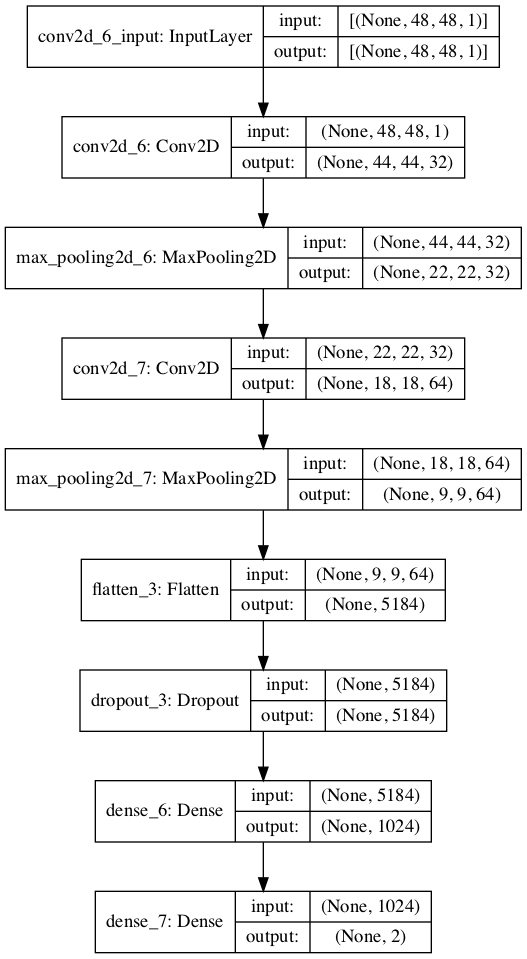

In [157]:
plot_model(cnn_asym, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png')

In [158]:
cnn_asym.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

#### Training and Evaluating the Model

In [159]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [160]:
test_data.batch_size

32

In [161]:
cnn_asym.fit(train_data, 
             validation_data=test_data, 
             epochs=100, 
             batch_size=32,
             callbacks=[early_stopping])

Epoch 1/100
5/5 [==============================] - 1s 152ms/step - loss: 103.0566 - accuracy: 0.5430 - val_loss: 1.6759 - val_accuracy: 0.6111
Epoch 2/100
5/5 [==============================] - 1s 100ms/step - loss: 1.7774 - accuracy: 0.5230 - val_loss: 0.6322 - val_accuracy: 0.6667
Epoch 3/100
5/5 [==============================] - 0s 95ms/step - loss: 0.6337 - accuracy: 0.6238 - val_loss: 0.4803 - val_accuracy: 0.6389
Epoch 4/100
5/5 [==============================] - 0s 93ms/step - loss: 0.7024 - accuracy: 0.5341 - val_loss: 0.4644 - val_accuracy: 0.6667
Epoch 5/100
5/5 [==============================] - 0s 97ms/step - loss: 0.7531 - accuracy: 0.5161 - val_loss: 0.4631 - val_accuracy: 0.6667
Epoch 6/100
5/5 [==============================] - 0s 95ms/step - loss: 0.6410 - accuracy: 0.4754 - val_loss: 0.4671 - val_accuracy: 0.6667
Epoch 7/100
5/5 [==============================] - 1s 96ms/step - loss: 0.6305 - accuracy: 0.5234 - val_loss: 0.4705 - val_accuracy: 0.6667
Epoch 8/100
5/5 

#### Making predictions

In [162]:
y_pred = cnn_asym.predict(test_data)

In [163]:
y_pred[0]

array([0.00130844, 0.9986916 ], dtype=float32)

In [164]:
test_data.class_indices

{'B': 0, 'M': 1}

In [165]:
predicted = [np.argmax(w) for w in y_pred]
expected = test_data.labels

In [166]:
from sklearn.metrics import confusion_matrix, classification_report

In [167]:
confusion_matrix(expected, predicted)

array([[ 2, 10],
       [ 0, 24]])

In [168]:
print(classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       1.00      0.17      0.29        12
           1       0.71      1.00      0.83        24

    accuracy                           0.72        36
   macro avg       0.85      0.58      0.56        36
weighted avg       0.80      0.72      0.65        36



### TRAIN AND EVALUATE MODEL FOR CALCIFICATIONS

In [38]:
# TRAIN AND TEST DATA FOR THE MASSES
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [39]:
calcifications = test_sub[(test_sub.ab_class == 'CALC')]

In [40]:
data_generator = ImageDataGenerator(width_shift_range=.1, 
                                    height_shift_range=.1, 
                                    rotation_range=180,
                                    zoom_range=.1,
                                    horizontal_flip=True,
                                    validation_split=.2)

In [41]:
train_data = data_generator.flow_from_dataframe(calcifications, 
                                                x_col="subsample_path", 
                                                y_col="severity",
                                                class_mode="categorical",
                                                target_size=(48,48),
                                                subset="training",
                                                color_mode="grayscale",
                                                shuffle=True)
test_data = data_generator.flow_from_dataframe(calcifications, 
                                               x_col="subsample_path", 
                                               y_col="severity",
                                               class_mode="categorical",
                                               target_size=(48,48),
                                               subset="validation",
                                               color_mode="grayscale",
                                               shuffle=False)


Found 212 validated image filenames belonging to 2 classes.
Found 52 validated image filenames belonging to 2 classes.


In [44]:
# create neural network
from tensorflow.keras.models import Sequential

In [45]:
cnn_calc = Sequential()

In [46]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

In [47]:
# add layers
cnn_calc.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(48, 48, 1)))

In [48]:
# Add a Pooling Layer
cnn_calc.add(MaxPooling2D(pool_size=(2, 2)))

In [49]:
cnn_calc.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))

In [50]:
cnn_calc.add(MaxPooling2D(pool_size=(2,2)))

#### Flattening the results

In [51]:
cnn_calc.add(Flatten())

#### Add dense layer to reduce the number of features

In [52]:
from tensorflow.keras.layers import Dropout


In [53]:
cnn_calc.add(Dropout(0.5)) # to avoid overfitting , drop 50%

In [54]:
cnn_calc.add(Dense(units=1024, activation='relu'))

#### Dense layer to produce final output

In [55]:
cnn_calc.add(Dense(units=2, activation='softmax')) # 2 units - B/ M

In [56]:
cnn_calc.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 44, 44, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 5184)              0         
_________________________________________________________________
dropout (Dropout)            (None, 5184)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)             

#### Visualise the Model's Structure

In [57]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

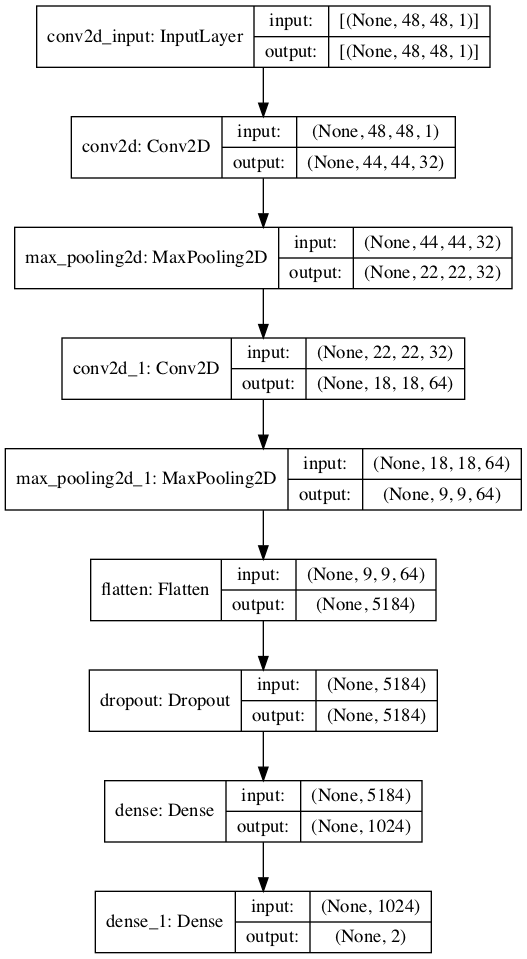

In [58]:
plot_model(cnn_calc, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png')

In [59]:
cnn_calc.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

#### Training and Evaluating the Model

In [60]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [61]:
test_data.batch_size

32

In [62]:
cnn_calc.fit(train_data, 
             validation_data=test_data, 
             epochs=100, 
             batch_size=32,
             callbacks=[early_stopping])

Epoch 1/100
7/7 [==============================] - 2s 183ms/step - loss: 51.4684 - accuracy: 0.4708 - val_loss: 0.6943 - val_accuracy: 0.4615
Epoch 2/100
7/7 [==============================] - 1s 89ms/step - loss: 0.6877 - accuracy: 0.5805 - val_loss: 0.6989 - val_accuracy: 0.3077
Epoch 3/100
7/7 [==============================] - 1s 108ms/step - loss: 0.6905 - accuracy: 0.5986 - val_loss: 0.7065 - val_accuracy: 0.3077
Epoch 4/100
7/7 [==============================] - 1s 115ms/step - loss: 0.6849 - accuracy: 0.6222 - val_loss: 0.7168 - val_accuracy: 0.3077
Epoch 5/100
7/7 [==============================] - 1s 155ms/step - loss: 0.6842 - accuracy: 0.5862 - val_loss: 0.7276 - val_accuracy: 0.3077
Epoch 6/100
7/7 [==============================] - 1s 102ms/step - loss: 0.6797 - accuracy: 0.5976 - val_loss: 0.7405 - val_accuracy: 0.3077


#### Making predictions

In [63]:
y_pred = cnn_calc.predict(test_data)

In [64]:
y_pred[0]

array([0.5003599 , 0.49964008], dtype=float32)

In [65]:
test_data.class_indices

{'B': 0, 'M': 1}

In [66]:
predicted = [np.argmax(w) for w in y_pred]
expected = test_data.labels

In [67]:
from sklearn.metrics import confusion_matrix, classification_report

In [68]:
confusion_matrix(expected, predicted)

array([[15,  1],
       [32,  4]])

In [69]:
print(classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.32      0.94      0.48        16
           1       0.80      0.11      0.20        36

    accuracy                           0.37        52
   macro avg       0.56      0.52      0.34        52
weighted avg       0.65      0.37      0.28        52



### TRAIN AND EVALUATE MODEL FOR ALL ABNORMALITIES

In [199]:
# TRAIN AND TEST DATA FOR THE ASYMMETRY
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [200]:
all_ab = test_sub[test_sub.ab_class != 'NORM']
all_ab

,ab_class,bg,severity,subsample_path
mdb001_0_rotated,CIRC,G,B,../subsamples/mdb001_0_rotated.png
mdb001_0_mirr_lr,CIRC,G,B,../subsamples/mdb001_0_mirr_lr.png
mdb001_0_mirr_tp,CIRC,G,B,../subsamples/mdb001_0_mirr_tp.png
mdb001_90_rotated,CIRC,G,B,../subsamples/mdb001_90_rotated.png
mdb001_90_mirr_lr,CIRC,G,B,../subsamples/mdb001_90_mirr_lr.png
...,...,...,...,...
mdb315_180_mirr_lr,CIRC,D,B,../subsamples/mdb315_180_mirr_lr.png
mdb315_180_mirr_tp,CIRC,D,B,../subsamples/mdb315_180_mirr_tp.png
mdb315_270_rotated,CIRC,D,B,../subsamples/mdb315_270_rotated.png
mdb315_270_mirr_lr,CIRC,D,B,../subsamples/mdb315_270_mirr_lr.png


In [201]:
data_generator = ImageDataGenerator(width_shift_range=.1, 
                                    height_shift_range=.1, 
                                    rotation_range=180,
                                    zoom_range=.1,
                                    horizontal_flip=True,
                                    validation_split=.2)

In [202]:
train_data = data_generator.flow_from_dataframe(all_ab, 
                                                x_col="subsample_path", 
                                                y_col="severity",
                                                class_mode="categorical",
                                                target_size=(48,48),
                                                subset="training",
                                                color_mode="grayscale",
                                                shuffle=True)
test_data = data_generator.flow_from_dataframe(all_ab, 
                                               x_col="subsample_path", 
                                               y_col="severity",
                                               class_mode="categorical",
                                               target_size=(48,48),
                                               subset="validation",
                                               color_mode="grayscale",
                                               shuffle=False)


Found 1076 validated image filenames belonging to 2 classes.
Found 268 validated image filenames belonging to 2 classes.


In [203]:
# create neural network
from tensorflow.keras.models import Sequential

In [204]:
cnn_test_sub = Sequential()

In [205]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

In [206]:
# add layers
cnn_test_sub.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(48, 48, 1)))

In [207]:
# Add a Pooling Layer
cnn_test_sub.add(MaxPooling2D(pool_size=(2, 2)))

In [208]:
cnn_test_sub.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))

In [209]:
cnn_test_sub.add(MaxPooling2D(pool_size=(2,2)))

#### Flattening the results

In [210]:
cnn_test_sub.add(Flatten())

#### Add dense layer to reduce the number of features

In [211]:
from tensorflow.keras.layers import Dropout


In [212]:
cnn_test_sub.add(Dropout(0.5)) # to avoid overfitting , drop 50%

In [213]:
cnn_test_sub.add(Dense(units=1024, activation='relu'))

#### Dense layer to produce final output

In [214]:
cnn_test_sub.add(Dense(units=2, activation='softmax')) # 2 units - B/ M / A for NORM

In [215]:
cnn_test_sub.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 44, 44, 32)        832       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 18, 18, 64)        51264     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 5184)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 5184)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)             

#### Visualise the Model's Structure

In [216]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

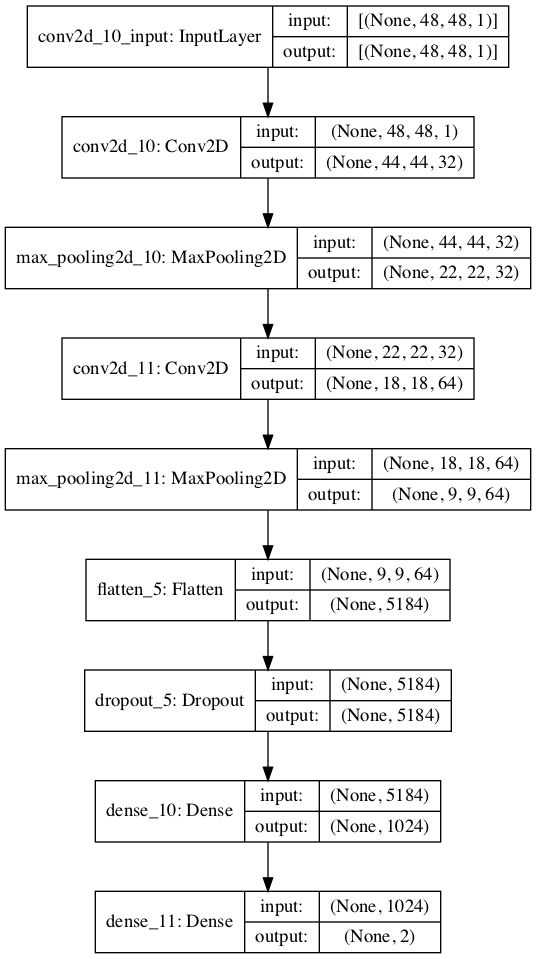

In [217]:
plot_model(cnn_test_sub, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png')

In [218]:
cnn_test_sub.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

#### Training and Evaluating the Model

In [219]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [220]:
test_data.batch_size

32

In [221]:
cnn_test_sub.fit(train_data, 
             validation_data=test_data, 
             epochs=100, 
             batch_size=32,
             callbacks=[early_stopping])

Epoch 1/100
34/34 [==============================] - 4s 95ms/step - loss: 52.5799 - accuracy: 0.4788 - val_loss: 0.7164 - val_accuracy: 0.2052
Epoch 2/100
34/34 [==============================] - 3s 84ms/step - loss: 0.7062 - accuracy: 0.5231 - val_loss: 0.7666 - val_accuracy: 0.7687
Epoch 3/100
34/34 [==============================] - 3s 81ms/step - loss: 0.7264 - accuracy: 0.5143 - val_loss: 0.7374 - val_accuracy: 0.7724
Epoch 4/100
34/34 [==============================] - 3s 83ms/step - loss: 0.6960 - accuracy: 0.5183 - val_loss: 0.7220 - val_accuracy: 0.7799
Epoch 5/100
34/34 [==============================] - 3s 81ms/step - loss: 0.7133 - accuracy: 0.4927 - val_loss: 0.7083 - val_accuracy: 0.7836
Epoch 6/100
34/34 [==============================] - 3s 82ms/step - loss: 0.6932 - accuracy: 0.5238 - val_loss: 0.6983 - val_accuracy: 0.7948
Epoch 7/100
34/34 [==============================] - 3s 80ms/step - loss: 0.7015 - accuracy: 0.5096 - val_loss: 0.6978 - val_accuracy: 0.7836
Epoch

#### Making predictions

In [222]:
y_pred = cnn_test_sub.predict(test_data)

In [223]:
y_pred[0]

array([0.5171226 , 0.48287734], dtype=float32)

In [224]:
test_data.class_indices

{'B': 0, 'M': 1}

In [225]:
predicted = [np.argmax(w) for w in y_pred]
expected = test_data.labels

In [226]:
from sklearn.metrics import confusion_matrix, classification_report

In [227]:
confusion_matrix(expected, predicted)

array([[208,   0],
       [ 58,   2]])

In [228]:
print(classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88       208
           1       1.00      0.03      0.06        60

    accuracy                           0.78       268
   macro avg       0.89      0.52      0.47       268
weighted avg       0.83      0.78      0.70       268



In [229]:
tn, fp, fn, tp = confusion_matrix(expected, predicted).ravel()

In [230]:
tn

208

In [231]:
fp

0

In [232]:
fn

58

In [233]:
tp

2